In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split
import gc
from keras import backend as K
import glob
import sklearn

%matplotlib inline

Using TensorFlow backend.


In [2]:
def create_train_test_data(test_size=0.2):
    car_files = glob.glob("resizedImage\cars\*")
    artilary_files = glob.glob("resizedImage\militaryArtillary\*")
    tank_files = glob.glob("resizedImage\militaryTank\*")
    truck_files = glob.glob("resizedImage\militaryTruck\*")

    # Restrict cat and dog files here for testing
    #cat_list = [convert_image_to_data(i, num_pix, num_pix) for i in cat_files]
    #dog_list = [convert_image_to_data(i, num_pix, num_pix) for i in dog_files]

    y_car = np.zeros(len(car_files))
    y_artilary = np.ones(len(artilary_files))
    y_tank = np.ones(len(tank_files))
    y_truck = np.ones(len(truck_files))

    """
    print(len(car_files))
    print(len(artilary_files))
    print(len(tank_files))
    print(len(truck_files))
    """
    X = np.concatenate([car_files, artilary_files, tank_files, truck_files])
    """
    print(len(X))
    print(X[0])
    """
    print("Total Dataset = ", X.shape)
    y = np.concatenate([y_car, y_artilary, y_tank, y_truck])
    print("Total Labels = ", len(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)                                                
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = create_train_test_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Total Dataset =  (3186,)
Total Labels =  3186
(2548,)
(2548,)
(638,)
(638,)


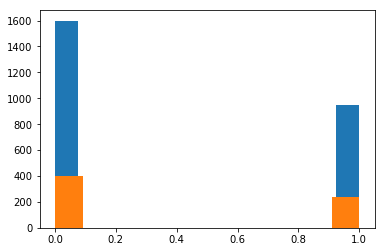

In [4]:
#hist = np.histogram(y_train, bins=2,range = (0,1))
plt.hist(y_train, bins='auto')
plt.hist(y_test, bins='auto')
plt.show()

In [5]:
# Creating a generator
def generator(X,y, batch_size=32):
    num_samples = len(X)
    while 1: # Loop forever so the generator never terminates
        combined = list(zip(X,y))
        sklearn.utils.shuffle(combined) # shuffle data
        for offset in range(0, num_samples, batch_size):
            batch_samples = combined[offset:offset+batch_size] # batch of 32 feeded in the batch samples
            #batch_Y = Y[offset:offset+batch_size]
            images = [] # empty arrays for processing
            labels = []
            for batch_sample in batch_samples:
                #print( batch_sample[0].split('/')[-1])
                #name = '../data/IMG/'+batch_sample[0].split('\\')[-1] #batch_sample[0].split('/')[-1] # <--- should be used if code running on windows instead of EC2
                center_image = cv2.imread(batch_sample[0])
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB) # takes care of the BGR to RGB conversion. since finally the simulator outputs RGB
                #center_angle = float(batch_sample[1])
                images.append(center_image)
                labels.append(batch_sample[1])

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(labels)
            yield sklearn.utils.shuffle(X_train, y_train) # shuffle data again


In [6]:
# compile and train the model using the generator function
train_generator = generator(X_train, y_train, batch_size=32)
#validation_generator = generator(validation_samples, batch_size=32)

In [18]:
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(256,256,3)))
# Cropping to focus only on road
#model.add(Cropping2D(cropping=((50,20), (0,0))))
#Covolution Layer 1 
model.add(Convolution2D(24, 5, 5, activation='relu', subsample=(2, 2)))
#Covolution Layer 2
model.add(Convolution2D(36, 5, 5, activation='relu', subsample=(2, 2)))
#Covolution Layer 3
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2, 2)))
#Covolution Layer 4
model.add(Convolution2D(64, 3, 3, activation='relu'))
#Covolution Layer 5
model.add(Convolution2D(64, 3, 3, activation='relu'))
#Dropout Layer 
model.add(Dropout(p = 0.5)) # can be tuned
# Flatten for passing to Fully Connected layers
model.add(Flatten())
# FC 1
model.add(Dense(100))#, activation='elu')) <--- Can add relu here too. But I thought it wasn't necessary later on.
# FC 2
model.add(Dense(50))#, activation='elu'))
# FC 3
model.add(Dense(10))#, activation='elu'))
# FC 4
model.add(Dense(1))

C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
  import sys
C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
  if __name__ == '__main__':
C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  del sys.path[0]
C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy']) # Using default learning rate and MSE as loss function
model.fit_generator(train_generator, samples_per_epoch= len(X_train), nb_epoch=13)

C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\kapil\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=2548, epochs=13)`
  


Epoch 1/13
2548/2548 [==============================] - 153s 60ms/step - loss: 0.0095 - acc: 0.9999
Epoch 2/13
2548/2548 [==============================] - 151s 59ms/step - loss: 0.0089 - acc: 0.9999
Epoch 3/13
2548/2548 [==============================] - 152s 60ms/step - loss: 0.0067 - acc: 1.0000
Epoch 4/13
2548/2548 [==============================] - 162s 63ms/step - loss: 0.0047 - acc: 1.0000
Epoch 5/13
2548/2548 [==============================] - 152s 60ms/step - loss: 0.0046 - acc: 1.0000
Epoch 6/13
2548/2548 [==============================] - 152s 59ms/step - loss: 0.0045 - acc: 1.0000
Epoch 7/13
2548/2548 [==============================] - 152s 60ms/step - loss: 0.0033 - acc: 1.0000
Epoch 8/13
2548/2548 [==============================] - 152s 60ms/step - loss: 0.0030 - acc: 1.0000
Epoch 9/13
2548/2548 [==============================] - 153s 60ms/step - loss: 0.0036 - acc: 1.0000
Epoch 10/13
2548/2548 [==============================] - 151s 59ms/step - loss: 0.0033 - acc: 1.0000

In [21]:
model.save('model.h5')

In [16]:
model1 = load_model('model.h5')

In [17]:
# Creating a generator
def testCreator(X):
    images = []
    num_samples = len(X)
    for path in X:
        #print( batch_sample[0].split('/')[-1])
        #name = '../data/IMG/'+batch_sample[0].split('\\')[-1] #batch_sample[0].split('/')[-1] # <--- should be used if code running on windows instead of EC2
        center_image = cv2.imread(path)
        center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB) # takes care of the BGR to RGB conversion. since finally the simulator outputs RGB
        #center_angle = float(batch_sample[1])
        images.append(center_image)
        # trim image to only see section with road
    X_test = np.array(images)
    return X_test

In [18]:
#model.evaluate(X_test, y = y_test,batch_size=638, verbose=1)
PREDICTED_CLASSES = model1.predict_classes(testCreator(X_test), batch_size=638, verbose=1)
#print(type(PREDICTED_CLASSES))
#PREDICTED_CLASSES = (PREDICTED_CLASSES>=0.5)
y_test = y_test.reshape(638,1)
temp = sum(y_test == PREDICTED_CLASSES)/len(y_test)
print(y_test.shape)
print(temp)

638/638 [==============================] - 1s 1ms/step
(638, 1)
[0.95611285]


In [19]:
def convert_frames_to_video():
    output = glob.glob("output_M\*")
    frame_array = []
    #print(frame_array[0])
    
    #out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, (600,600))
    for i in output:
        # writing to a image array
        img = cv2.imread(i)
        frame_array.append(img)
        #cv2.resizeWindow('image', 1000,1000)
        #cv2.imshow('image',frame_array[i])    
        #cv2.waitKey(500)
        #cv2.destroyAllWindows()
    out = cv2.VideoWriter('D:\output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (600,600))
    for i in range(len(frame_array)):
        out.write(frame_array[i])
    out.release()

In [20]:
PREDICTED_CLASSES = model1.predict_classes(testCreator(X_test), batch_size=638, verbose=1)
#print(type(PREDICTED_CLASSES))
#PREDICTED_CLASSES = (PREDICTED_CLASSES>=0.5)
y_test = y_test.reshape(638,1)
temp = sum(y_test == PREDICTED_CLASSES)/len(y_test)
print(y_test.shape)
print(temp)



images = testCreator(X_test)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,150)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

combined = zip(images,PREDICTED_CLASSES)
frame_array = []
it = 0
for i in combined:
    
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    img = cv2.cvtColor(i[0], cv2.COLOR_BGR2RGB)
    if(i[1] == 1):
                    cv2.putText(img,'Military Vechile', 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
    else:
                  cv2.putText(img,'Not a Military Vechile', 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
    cv2.imwrite("output_M/" + str(it)+".png",img)
    it = it+1
    frame_array.append(img)
    #cv2.resizeWindow('image', 1000,1000)
    #cv2.imshow('image',img)    
    #cv2.waitKey(33)
    #cv2.destroyAllWindows()
    

638/638 [==============================] - 1s 896us/step
(638, 1)
[0.95611285]
